In [4]:
# ===== Cell 1: Upload TSP file =====
from google.colab import files

print("Please upload the 'berlin52.tsp' file.")
uploaded = files.upload()

# Take the first uploaded filename
filename = next(iter(uploaded))
print("Uploaded file:", filename)


Please upload the 'berlin52.tsp' file.


Saving berlin52.tsp to berlin52 (2).tsp
Uploaded file: berlin52 (2).tsp


In [5]:
# ===== Cell 2: obj and fitness and dist matrix Functions & Data arranging =====
import math
import random
import statistics
import matplotlib.pyplot as plt

def read_tsp_file(fname):
    """Reads the uploaded TSP file and returns a list of id (x, y) coordinates."""
    coords = []
    with open(fname, 'r') as f:
        lines = f.readlines()

    start_reading = False
    for line in lines:
        if "NODE_COORD_SECTION" in line:
            start_reading = True
            continue
        if "EOF" in line:
            break
        if start_reading:
            parts = line.strip().split()
            # We look for lines with ID X Y
            if len(parts) >= 3:
                coords.append((float(parts[1]), float(parts[2])))
    return coords
# for easy distance access

def get_distance_matrix(city_list):
    """Pre-calculates distances between all cities."""
    n = len(city_list)
    matrix = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                # Euclidean distance func
                dist = math.sqrt((city_list[i][0] - city_list[j][0])**2 +
                                 (city_list[i][1] - city_list[j][1])**2)
                matrix[i][j] = dist
    return matrix

# obj func is dist: calc tour distance from city 1 back to it
def calculate_tour_distance(tour, matrix):
    total_dist = 0.0
    for i in range(len(tour)):
        from_city = tour[i]
        to_city = tour[(i + 1) % len(tour)]  # Connect last city back to first
        total_dist += matrix[from_city][to_city]
    return total_dist

# fitness is 1/ dist  making it max op (used in GA, not needed in SA but ok to keep)
def calculate_fitness(tour, matrix):
    dist = calculate_tour_distance(tour, matrix)
    if dist == 0:
        return float('inf')
    return 1.0 / dist

# Load the Data using the filename from Cell 1
cities = read_tsp_file(filename)
dist_matrix = get_distance_matrix(cities)
NUM_CITIES = len(cities)

print(f"Successfully loaded {NUM_CITIES} cities from {filename}.")


Successfully loaded 52 cities from berlin52 (2).tsp.


In [6]:
# ===== Cell 3: SA solution representation and swap neighbor operator =====

def sa_create_random_tour():
    """Create one random feasible TSP tour."""
    tour = list(range(NUM_CITIES))
    random.shuffle(tour)
    return tour

def sa_swap_neighbor(tour):
    """
    Neighborhood operator for SA:
    generate neighbor by swapping two random cities in the tour.
    """
    new_tour = tour.copy()
    i, j = random.sample(range(len(new_tour)), 2)
    new_tour[i], new_tour[j] = new_tour[j], new_tour[i]
    return new_tour


In [39]:
# ===== Cell 4: Main SA Algorithm =====

def run_simulated_annealing(initial_temp, alpha, inner_iters,
                            max_outer_iters=1000):
    """
    Simulated Annealing for TSP (student-style, two loops).

    - outer loop: temperature levels (we repeat 1000 times)
    - inner loop: equilibrium at fixed temperature (stay inner_iters times)
    - stopping condition: outer reaches max_outer_iters (e.g., 1000),
      similar to 1000 generations in GA.
    """


    # start from random solution
    current_tour = sa_create_random_tour()
    current_dist = calculate_tour_distance(current_tour, dist_matrix)

    best_tour = current_tour.copy()
    best_dist = current_dist

    T = float(initial_temp)

    history = []
    iter_index = 0   # just for plotting convergence (x-axis), not stopping

    # Outer loop: temperature levels
    for outer in range(max_outer_iters):

        # Inner loop: equilibrium at this temperature
        inner = 0
        while inner < inner_iters:
            # 1) generate neighbor using swap
            neighbor_tour = sa_swap_neighbor(current_tour)
            neighbor_dist = calculate_tour_distance(neighbor_tour, dist_matrix)

            # 2) compute change (we minimize distance)
            delta = neighbor_dist - current_dist

            # 3) Metropolis acceptance
            if delta < 0:
                accept = True
            else:
                if T <= 0:
                    accept = False
                else:
                    prob = math.exp(-delta / T)
                    accept = (random.random() < prob)

            # 4) update current solution if accepted
            if accept:
                current_tour = neighbor_tour
                current_dist = neighbor_dist

            # 5) update global best
            if current_dist < best_dist:
                best_dist = current_dist
                best_tour = current_tour.copy()

            # 6) save history for convergence graph
            history.append({
                "iteration": outer,
                "current_length": current_dist,
                "best_length": best_dist,
                "temperature": T
            })

            iter_index += 1
            inner += 1

        # After finishing equilibrium at this temperature, cool down
        # geometric cooling schedule: T_next = alpha * T
        T = alpha * T

    return best_dist, history, best_tour


In [40]:
# ===== Cell 5: SA Hyperparameter Tuning + Auto Best Selection =====
import time
import pandas as pd

def tune_sa_parameters():
    print("SA Hyperparameter Tuning (5 runs per value)\n")

    # Default values during tuning (One-Factor-At-a-Time)
    defaults = {
        "initial_temp": 1000.0,
        "inner_iters": 50,
        "alpha": 0.95,
        "max_outer_iters": 500   # fewer temperature levels during tuning
    }

    # Parameters to tune One-Factor-At-a-Time (3 values each)
    tests = [
        ("Initial Temperature", "initial_temp", [500.0, 1000.0, 2000.0]),
        ("Equilibrium State (inner iters)", "inner_iters", [20, 50, 100]),
        ("Cooling Rate (alpha) for geometric", "alpha", [0.90, 0.95, 0.99])
    ]

    detailed_rows = []
    summary_rows = []

    for param_name, key, values in tests:
        print(f"Testing {param_name}:")
        print(f"{'Value':<10} | {'Avg Dist':<12} | {'Std Dev':<10}")
        print("-" * 40)

        for val in values:
            best_list = []

            for run_idx in range(1, 6):  # 5 runs per value
                params = defaults.copy()
                params[key] = val

                best_d, _, _ = run_simulated_annealing(
                    initial_temp=params["initial_temp"],
                    alpha=params["alpha"],
                    inner_iters=params["inner_iters"],
                    max_outer_iters=params["max_outer_iters"],

                )
                best_list.append(best_d)

                detailed_rows.append({
                    "Parameter": param_name,
                    "Key": key,
                    "Value": val,
                    "Run": run_idx,
                    "Best_Distance": best_d
                })

            avg_best = statistics.mean(best_list)
            std_best = statistics.stdev(best_list) if len(best_list) > 1 else 0.0

            summary_rows.append({
                "Parameter": param_name,
                "Key": key,
                "Value": val,
                "Avg_Best_Distance": avg_best,
                "Std_Best_Distance": std_best
            })

            print(f"{str(val):<10} | {avg_best:<12.2f} | {std_best:<10.2f}")

        print()  # Blank line between parameter blocks

    detailed_df = pd.DataFrame(detailed_rows)
    summary_df = pd.DataFrame(summary_rows)

    print("=============== DETAILED RESULTS (each run) ===============")
    display(detailed_df)
    print("\n=============== SUMMARY RESULTS (avg & std per value) ===============")
    display(summary_df)

    return detailed_df, summary_df


# Run tuning
sa_detailed_df, sa_summary_df = tune_sa_parameters()

# ===== Automatically pick best SA parameters (lowest Std per parameter) =====

def get_best_value_by_std(summary_df, key_name):
    """Return the row with the lowest Std_Best_Distance for the given Key."""
    sub = summary_df[summary_df["Key"] == key_name]
    best_idx = sub["Std_Best_Distance"].idxmin()
    return sub.loc[best_idx]

best_init_row   = get_best_value_by_std(sa_summary_df, "initial_temp")
best_inner_row  = get_best_value_by_std(sa_summary_df, "inner_iters")
best_alpha_row  = get_best_value_by_std(sa_summary_df, "alpha")

# Global best values to be used in later cells
SA_BEST_INITIAL_TEMP = float(best_init_row["Value"])
SA_BEST_INNER_ITERS  = int(best_inner_row["Value"])
SA_BEST_ALPHA        = float(best_alpha_row["Value"])

print("\n===== BEST SA HYPERPARAMETERS AFTER TUNING (BASED ON STABILITY) =====")
print(f"BEST_INITIAL_TEMP   = {SA_BEST_INITIAL_TEMP}")
print(f"BEST_INNER_ITERS    = {SA_BEST_INNER_ITERS}")
print(f"BEST_ALPHA          = {SA_BEST_ALPHA}")


SA Hyperparameter Tuning (5 runs per value)

Testing Initial Temperature:
Value      | Avg Dist     | Std Dev   
----------------------------------------
500.0      | 10182.46     | 723.75    
1000.0     | 9749.20      | 209.31    
2000.0     | 9927.09      | 437.11    

Testing Equilibrium State (inner iters):
Value      | Avg Dist     | Std Dev   
----------------------------------------
20         | 10804.35     | 400.49    
50         | 10081.41     | 709.39    
100        | 9669.45      | 591.08    

Testing Cooling Rate (alpha) for geometric:
Value      | Avg Dist     | Std Dev   
----------------------------------------
0.9        | 10672.74     | 543.77    
0.95       | 9563.93      | 197.41    
0.99       | 9685.75      | 675.90    

=============== DETAILED RESULTS (each run) ===============


,Parameter,Key,Value,Run,Best_Distance
0,Initial Temperature,initial_temp,500.00,1,9468.134563
1,Initial Temperature,initial_temp,500.00,2,10188.338792
2,Initial Temperature,initial_temp,500.00,3,11375.557402
3,Initial Temperature,initial_temp,500.00,4,9791.791304
4,Initial Temperature,initial_temp,500.00,5,10088.472944
5,Initial Temperature,initial_temp,1000.00,1,9834.043879
6,Initial Temperature,initial_temp,1000.00,2,9735.201250
7,Initial Temperature,initial_temp,1000.00,3,9482.816168
8,Initial Temperature,initial_temp,1000.00,4,9649.768487
9,Initial Temperature,initial_temp,1000.00,5,10044.160689



=============== SUMMARY RESULTS (avg & std per value) ===============


,Parameter,Key,Value,Avg_Best_Distance,Std_Best_Distance
0,Initial Temperature,initial_temp,500.00,10182.459001,723.745880
1,Initial Temperature,initial_temp,1000.00,9749.198095,209.310313
2,Initial Temperature,initial_temp,2000.00,9927.090144,437.111275
3,Equilibrium State (inner iters),inner_iters,20.00,10804.348026,400.493946
4,Equilibrium State (inner iters),inner_iters,50.00,10081.413408,709.392650
5,Equilibrium State (inner iters),inner_iters,100.00,9669.452035,591.077427
6,Cooling Rate (alpha) for geometric,alpha,0.90,10672.744915,543.765307
7,Cooling Rate (alpha) for geometric,alpha,0.95,9563.931525,197.405780
8,Cooling Rate (alpha) for geometric,alpha,0.99,9685.752836,675.896984



===== BEST SA HYPERPARAMETERS AFTER TUNING (BASED ON STABILITY) =====
BEST_INITIAL_TEMP   = 1000.0
BEST_INNER_ITERS    = 20
BEST_ALPHA          = 0.95


In [41]:
# ===== Cell 6: SA AFTER TUNING (10 runs with best values) =====

SA_MAX_OUTER_ITERS = 1000   # fair comparison with GA

best_distances = []
execution_times = []

print("SA AFTER TUNING (10 Runs)\n")
print(f"Using best parameters from tuning:")
print(f"  Initial Temp  = {SA_BEST_INITIAL_TEMP}")
print(f"  inner_iters   = {SA_BEST_INNER_ITERS}")
print(f"  alpha         = {SA_BEST_ALPHA}\n")

for run_id in range(1, 11):
    start_time = time.time()

    best_d, _, _ = run_simulated_annealing(
        initial_temp=SA_BEST_INITIAL_TEMP,
        alpha=SA_BEST_ALPHA,
        inner_iters=SA_BEST_INNER_ITERS,
        max_outer_iters=SA_MAX_OUTER_ITERS,

    )

    elapsed = time.time() - start_time

    best_distances.append(best_d)
    execution_times.append(elapsed)

    print(f"Run {run_id}: Best Distance = {best_d:.2f} | Time = {elapsed:.4f} s")

best_of_all = min(best_distances)
avg_best = statistics.mean(best_distances)
avg_time = statistics.mean(execution_times)

print("\nSummary (After Tuning):")
print(f"Best Best-Distance     : {best_of_all:.2f}")
print(f"Average Best-Distance  : {avg_best:.2f}")
print(f"Average Time (seconds) : {avg_time:.4f}")


SA AFTER TUNING (10 Runs)

Using best parameters from tuning:
  Initial Temp  = 1000.0
  inner_iters   = 20
  alpha         = 0.95

Run 1: Best Distance = 10441.02 | Time = 0.1850 s
Run 2: Best Distance = 9945.13 | Time = 0.1998 s
Run 3: Best Distance = 10757.22 | Time = 0.1793 s
Run 4: Best Distance = 10073.70 | Time = 0.2004 s
Run 5: Best Distance = 10274.36 | Time = 0.4206 s
Run 6: Best Distance = 10104.45 | Time = 0.4940 s
Run 7: Best Distance = 9759.71 | Time = 0.3238 s
Run 8: Best Distance = 11282.22 | Time = 0.1768 s
Run 9: Best Distance = 10359.73 | Time = 0.2001 s
Run 10: Best Distance = 10271.73 | Time = 0.1771 s

Summary (After Tuning):
Best Best-Distance     : 9759.71
Average Best-Distance  : 10326.93
Average Time (seconds) : 0.2557


In [45]:
# ===== Cell 7: SA BEFORE TUNING (10 runs with default values) =====

SA_DEFAULT_INITIAL_TEMP = 1000.0
SA_DEFAULT_INNER_ITERS  = 50
SA_DEFAULT_ALPHA        = 0.95

best_distances_default = []
execution_times_default = []

print("SA BEFORE TUNING (10 Runs)\n")
for run_id in range(1, 11):
    start_time = time.time()

    best_d, _, _ = run_simulated_annealing(
        initial_temp=SA_DEFAULT_INITIAL_TEMP,
        alpha=SA_DEFAULT_ALPHA,
        inner_iters=SA_DEFAULT_INNER_ITERS,
        max_outer_iters=SA_MAX_OUTER_ITERS,

    )

    elapsed = time.time() - start_time

    best_distances_default.append(best_d)
    execution_times_default.append(elapsed)

    print(f"Run {run_id}: Best Distance = {best_d:.2f} | Time = {elapsed:.4f} s")

best_of_all_default = min(best_distances_default)
avg_best_default = statistics.mean(best_distances_default)
avg_time_default = statistics.mean(execution_times_default)

print("\nSummary (Before Tuning):")
print(f"Best Best-Distance     : {best_of_all_default:.2f}")
print(f"Average Best-Distance  : {avg_best_default:.2f}")
print(f"Average Time (seconds) : {avg_time_default:.4f}")


SA BEFORE TUNING (10 Runs)

Run 1: Best Distance = 9014.78 | Time = 0.4828 s
Run 2: Best Distance = 10913.10 | Time = 0.4564 s
Run 3: Best Distance = 11558.56 | Time = 0.4642 s
Run 4: Best Distance = 10328.04 | Time = 0.4594 s
Run 5: Best Distance = 10229.01 | Time = 0.4665 s
Run 6: Best Distance = 10081.17 | Time = 0.4776 s
Run 7: Best Distance = 9648.78 | Time = 0.7098 s
Run 8: Best Distance = 9488.44 | Time = 0.8178 s
Run 9: Best Distance = 10204.70 | Time = 0.8104 s
Run 10: Best Distance = 10512.33 | Time = 0.7440 s

Summary (Before Tuning):
Best Best-Distance     : 9014.78
Average Best-Distance  : 10197.89
Average Time (seconds) : 0.5889


In [46]:
# ===== Cell 8: One SA run using best values (for convergence graph) =====

best_sa_dist_conv, sa_history_conv, sa_best_tour_conv = run_simulated_annealing(
    initial_temp=SA_BEST_INITIAL_TEMP,
    alpha=SA_BEST_ALPHA,
    inner_iters=SA_BEST_INNER_ITERS,
    max_outer_iters=SA_MAX_OUTER_ITERS
)

print(f"Single SA convergence run – Best Distance: {best_sa_dist_conv:.2f}")


Single SA convergence run – Best Distance: 11158.03


First 5 rows of SA convergence data:
 iteration  current_length  best_length  temperature
         0    28264.685485 28264.685485       1000.0
         0    28098.165056 28098.165056       1000.0
         0    27922.050071 27922.050071       1000.0
         0    27922.050071 27922.050071       1000.0
         0    28045.985018 27922.050071       1000.0


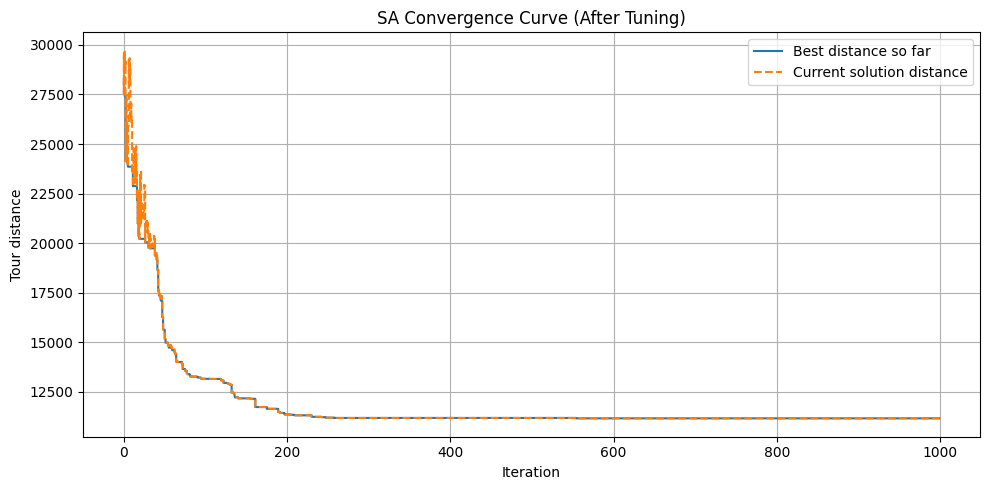

In [47]:
# ===== Cell 9: SA Convergence Graph =====
import pandas as pd

sa_conv_df = pd.DataFrame(sa_history_conv)

print("First 5 rows of SA convergence data:")
print(sa_conv_df.head().to_string(index=False))

plt.figure(figsize=(10, 5))

# Plot best distance so far
plt.plot(sa_conv_df["iteration"],
         sa_conv_df["best_length"],
         label="Best distance so far")

# Plot current solution distance
plt.plot(sa_conv_df["iteration"],
         sa_conv_df["current_length"],
         label="Current solution distance",
         linestyle="--")

plt.title("SA Convergence Curve (After Tuning)")
plt.xlabel("Iteration")
plt.ylabel("Tour distance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
